# How to check if two objects share covex space.

This notebook evaluates if the Convex Hulls of any objects in a field (2d) or volume (3d) are 'nested,' which means that the sum of their individual Convex Hulls is greater than that of the Convex Hull of their volumes considered additively.

Objects can only be returned as 'nesting' if the segmentation algorithm used upstream allows for surfaces to be concave. This means that some popular algorithms (i.e., StarDist) should always return a null set for objects in the same set of interest (i.e., nuclei). However, nesting can occur between convex polyhedra of different sets (i.e., nuclear segmentations overlayed with membrane segmentations).

In [1]:
# import modules
from __future__ import division, print_function
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.spatial import ConvexHull
%matplotlib inline

In [2]:
def find_file_names(fpath, str_id):
    
    files_in_dir = os.listdir(fpath)
    counter = 0
    names = ''
    
    for i in files_in_dir:
        if i.endswith(str_id):
            counter += 1
            names += (i + ',')
        else:
            continue

    names = names[:-1]
    names = np.asarray(names.split(sep = ','))
    
    return names, counter

###----------------------------------------------------------------------------------

def load_files(fpath, names, counter):
    
    files = [0] * counter
    for i in range(counter):
        files[i] = np.load(os.path.join(fpath, names[i]), allow_pickle=True)
    
    return files

###----------------------------------------------------------------------------------

def check_nesting(boundary_sets, ids):
    
    '''boundary_sets and ids should be arrays with the same shape in the first dimension.
    
       Parameters
       ----------
       boundary_sets : nd array containing point sets of object boundaries. d0 shape equals number of objects.
           Each sub array may have a different shape.
       
       ids : array_like. shape should be (n,).
           Each element is an integer identifying a single object.
           
       Returns
       -------
       nested_objs : 1d boolean (0,1) array.
           Where ==1, the two objects at that location in dual_idx are nested. 
           Where ==0, objects are not nested.
       
       dual_idx: 2d array. 
           Contains all possible combinations of object identifiers.'''
    
    n_objs = len(ids)
    mono_idx = np.arange(n_objs, dtype = int)
    dual_idx = np.asarray(list(combinations(mono_idx, 2)), dtype = int)
    
    mono_hull_vol = np.empty((n_objs,), dtype = np.float16)
    for i in mono_idx:
        mono_hull_vol[i] = ConvexHull(boundary_sets[i]).volume
    
    n_combos = dual_idx.shape[0]
    dual_hull_vol = np.empty((n_combos,), dtype = np.float16)
    additive_hull_vol = np.empty((n_combos,), dtype = np.float16)
    nested_objs = np.empty((n_combos,), dtype = np.uint8)
    
    for i in range(n_combos):
        a,b = dual_idx[i,:]
        dual_bnd_set = np.concatenate((boundary_sets[a], boundary_sets[b]), axis = 0)
        i_dual = ConvexHull(dual_bnd_set).volume
        i_add = mono_hull_vol[a] + mono_hull_vol[b]
        dual_hull_vol[i] = i_dual
        additive_hull_vol[i] = i_add
        
        if i_dual < i_add:
            nested_objs[i] = 1
        else:
            nested_objs[i] = 0
    
    return nested_objs, dual_idx

###----------------------------------------------------------------------------------

def check_nesting_verbose_return(boundary_sets, ids, retreive_vols = True):
    
    '''boundary_sets and ids should be arrays with the same shape in the first dimension.
    
       Parameters
       ----------
       boundary_sets : nd array containing point sets of object boundaries. d0 shape equals number of objects.
           Each sub array may have a different shape.
       
       ids : array_like. shape should be (n,).
           Each element is an integer identifying a single object.
           
       retreive_vols : if True will output volume measures of joined boundary set convex hulls, 
           two summed individaul hull volumes and single object convex hulls
           
       Returns
       -------
       nested_objs : 1d boolean (0,1) array.
           Where ==1, the two objects at that location in dual_idx are nested. 
           Where ==0, objects are not nested.
       
       dual_idx: 2d array. 
           Contains all possible combinations of object identifiers.
           
       dual_hull_vol: volume on the Convex Hull needed to surround two merged boundary point sets.
       
       addditive_hull_vol: summed volume of the Convex Hulls of two individual boundary point sets.
       
       mono_hull_vol: volume of an individual objects Convex Hull'''
    
    n_objs = len(ids)
    mono_idx = np.arange(n_objs, dtype = int)
    dual_idx = np.asarray(list(combinations(mono_idx, 2)), dtype = int)
    
    mono_hull_vol = np.empty((n_objs,), dtype = np.float16)
    for i in mono_idx:
        mono_hull_vol[i] = ConvexHull(boundary_sets[i]).volume
    
    n_combos = dual_idx.shape[0]
    dual_hull_vol = np.empty((n_combos,), dtype = np.float16)
    additive_hull_vol = np.empty((n_combos,), dtype = np.float16)
    nested_objs = np.empty((n_combos,), dtype = np.uint8)
    
    for i in range(n_combos):
        a,b = dual_idx[i,:]
        dual_bnd_set = np.concatenate((boundary_sets[a], boundary_sets[b]), axis = 0)
        i_dual = ConvexHull(dual_bnd_set).volume
        i_add = mono_hull_vol[a] + mono_hull_vol[b]
        dual_hull_vol[i] = i_dual
        additive_hull_vol[i] = i_add
        
        if i_dual < i_add:
            nested_objs[i] = 1
        else:
            nested_objs[i] = 0
    
    return nested_objs, dual_idx, dual_hull_vol, additive_hull_vol, mono_hull_vol

In [3]:
# load datasets -- users need to define a file path and a string identifier that all necessary files contain

fpath = r'cell_nests/example_boundary_sets'
str_id = r'um_bnds.npy'

names, counter = find_file_names(fpath, str_id)
boundary_sets = load_files(fpath, names, counter)

In [4]:
# run nesting_check function

ids = np.arange(names.shape[0])
nested_objs, dual_idx = check_nesting(boundary_sets, ids)

# return object pairs where nesting check is True (i.e., greater than zero)

nesting_detected = np.where(nested_objs == 1)
nesting_pairs = dual_idx[nesting_detected,:]
print(nesting_pairs)

[[[ 60 154]
  [ 72 139]
  [ 82 154]
  [136 180]]]


In [5]:
# run verbose nesting check (returns hull volumes as well)

nested_objs, dual_idx, dual_hull_vol, additive_hull_vol, mono_hull_vol = check_nesting_verbose_return(boundary_sets, ids)

# return object pairs where nesting check is True (i.e., greater than zero)

nesting_detected = np.where(nested_objs == 1)
nesting_pairs = dual_idx[nesting_detected,:]
print(nesting_pairs)

[[[ 60 154]
  [ 72 139]
  [ 82 154]
  [136 180]]]


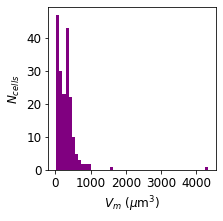

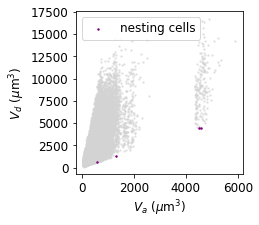

In [6]:
# plot histogram of individual object's convex hull volumes

plt.figure(figsize=(3,3))
plt.hist(mono_hull_vol, bins = 'fd', facecolor = 'purple')
plt.xlabel('$V_{m}$ ($\mu$m$^3$)', fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel('$N_{cells}$', fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

# plot dual hull (merged two boundary sets to created convex hull) volume v. additive hull volume (hull_1 + hull_2)

plt.figure(figsize=(3,3))
plt.scatter(additive_hull_vol, dual_hull_vol, c = 'lightgray', s = 2, alpha = 0.5)
plt.scatter(additive_hull_vol[nesting_detected], dual_hull_vol[nesting_detected], s = 2, c = 'purple', label = 'nesting cells')
plt.xlabel('$V_{a}$ ($\mu$m$^3$)', fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel('$V_{d}$ ($\mu$m$^3$)', fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)
plt.show()